# ROC curves and accuracy curves (HST training set)

In this notebook we show ROC curves and accuracy curves of several star/galaxy separation models: the machine leaarning model, the simple model (based on wwpsfKronDist), and PS1 model (based on $m_{\mathrm{iPSF}} - m_{\mathrm{iKron}}$). 

Simple model outperforms PS1 model, and the machine learning model shows the best performance in all range of brightness.

In [33]:
import sys,os,math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams["font.family"] = "sans-serif"
rcParams['font.sans-serif'] = ['DejaVu Sans']
from matplotlib import gridspec as grs
%matplotlib inline
from matplotlib import cm
from astropy.table import Table
import seaborn as sns
import statsmodels.nonparametric.api as smnp
from statsmodels.nonparametric.kernel_density import KDEMultivariate
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, accuracy_score, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.cross_validation import train_test_split
from scipy import interp

Functions to plot ROC curves and accuracy curves.  

In [43]:
def calc_CV_ROC(features, GT, score, n_splits, ML=False, classifier=None):
    cv = StratifiedKFold(n_splits=n_splits)
    tprs = []
    mean_fpr = np.linspace(0, 1, 5000)

    i = 0
    print('\n CV: ', end=' ')
    for train, test in cv.split(features, GT):
        print('%d/%d, '%(i+1, n_splits), end='')
        X_train, X_test, y_train, y_test = features[train], features[test], GT[train], GT[test]
        if ML: 
            score = classifier.fit(X_train, y_train).predict_proba(X_test)[:, 1]
            fpr, tpr, thresholds = roc_curve(y_test, score)
        else:
            fpr, tpr, thresholds = roc_curve(y_test, np.array(score)[test])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        i += 1

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0

    std_tpr = np.std(tprs, axis=0)/np.sqrt(n_splits)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    
    return(mean_fpr, mean_tpr, tprs_lower, tprs_upper)

def plot_ROC_curves(catalog, features, GT, n_splits, classifier, 
                    figname, savefig, 
                    extent =  [0, 1, 0, 1], extent_ins = [3e-3, 0.98e-2, 0.6, 0.78]):
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    
    ML_mean_fpr, ML_mean_tpr, ML_tprs_lower, ML_tprs_upper =\
        calc_CV_ROC(np.array(features), GT, None, n_splits, ML=True, classifier=classifier)    
    dist_mean_fpr, dist_mean_tpr, dist_tprs_lower, dist_tprs_upper =\
        calc_CV_ROC(np.array(features), GT, catalog.wwPSFKronDist, n_splits)
    i_mean_fpr, i_mean_tpr, i_tprs_lower, i_tprs_upper =\
        calc_CV_ROC(np.array(features), GT, -catalog.iPSFminusKron, n_splits)
    
    col_ML = 'black'
    col_dist = "C0"
    col_iminus = "C1"
    col_star = 'red'

    fig, ax = plt.subplots(figsize=(8, 5))
    axins = inset_axes(ax, width="58.5%",  
                       height="67.5%", loc=5)

    ax.grid(alpha=0.5, lw=0.5, c='grey', linestyle=':') 
    ax.tick_params(which="both", top=True, right=True)
    ax.minorticks_on()
    
    ax.fill_between(ML_mean_fpr, ML_tprs_lower, ML_tprs_upper, color=col_ML, alpha=.5)
    ax.fill_between(dist_mean_fpr, dist_tprs_lower, dist_tprs_upper, color=col_dist, alpha=.5)
    ax.fill_between(i_mean_fpr, i_tprs_lower, i_tprs_upper, color=col_iminus, alpha=.5)
    ax.plot(ML_mean_fpr, ML_mean_tpr, color=col_ML, lw=1, label='ML model')
    ax.plot(dist_mean_fpr, dist_mean_tpr, color=col_dist, lw=1, label='Simple model')
    ax.plot(i_mean_fpr, i_mean_tpr, color=col_iminus, lw=1, label='PS1 model')# label=r'm$_{\rm iPSF}-$m$_{\rm iKron}$')
    #ax.plot(i_mean_fpr[np.argmin(np.abs(i_thre--0.05))], 
    #    i_tpr[np.argmin(np.abs(i_thre--0.05))], '*', color=col_star_dist)

    ax.set_xlim(extent[0:2]); ax.set_ylim(extent[2:4])
    ax.tick_params(labelsize = 15)
    ax.set_xlabel('False Positive Ratio', fontsize=15)
    ax.set_ylabel('True Positive Ratio', fontsize=15)

    ax.legend( bbox_to_anchor=(0.01, 0.01, 1., 0.102), 
              loc=3, borderaxespad=0, fontsize=13)
    
    origin = 'lower'
    axins.tick_params(which="both", top=True)
    axins.minorticks_on()
    axins.fill_between(ML_mean_fpr, ML_tprs_lower, ML_tprs_upper, color=col_ML, alpha=.5)
    axins.fill_between(dist_mean_fpr, dist_tprs_lower, dist_tprs_upper, color=col_dist, alpha=.5)
    axins.fill_between(i_mean_fpr, i_tprs_lower, i_tprs_upper, color=col_iminus, alpha=.5)
    axins.plot(ML_mean_fpr, ML_mean_tpr, color=col_ML, lw=1.5)
    axins.plot(dist_mean_fpr, dist_mean_tpr, color=col_dist, lw=1.5)
    axins.plot(i_mean_fpr, i_mean_tpr, color=col_iminus, lw=1.5)
    axins.vlines([5e-3], 1e-3, 1, color='grey', lw=0.5)
    axins.set_xlim(extent_ins[0:2]); axins.set_ylim(extent_ins[2:4])
    axins.tick_params(labelsize = 15)
    plt.tight_layout()
    
    if savefig: 
        plt.savefig(figname)
    
    plt.show()
    
    return(None)

def calc_separtion_thre(thre, tpr, fpr, method):
    if method == 'info':
        return(thre[(tpr-fpr)==np.max(tpr-fpr)]-1e-10)
    if method == 'fom':
        return(thre[np.argmin(np.abs(fpr-0.005))])

def make_separation_label(thre, proba):
    return((np.sign(proba - thre).astype(int) + 1)/2)

def calc_accuracy_error(GT, labels, Xval, Xmin, Xmax, binwidth = 0.5, Nboot = 1):
    X_array = np.arange(Xmin , Xmax+binwidth, binwidth)
    acc_arr = np.zeros_like(X_array)
    boot_scatt = np.vstack((np.zeros_like(X_array), np.zeros_like(X_array)))

    for bin_num, binedge in enumerate(X_array):
        bin_sources = np.where((Xval >= binedge) & (Xval < binedge + binwidth))
        acc_arr[bin_num] = accuracy_score(GT[bin_sources], 
                                               labels[bin_sources])
        boot_acc = np.empty(Nboot)
        for i in range(Nboot):
            boot_sources = np.random.choice(bin_sources[0], len(bin_sources[0]))
            boot_acc[i] = accuracy_score(GT[boot_sources], 
                                                   labels[boot_sources])

        boot_scatt[:,bin_num] = np.percentile(boot_acc, [16, 84])
    return(X_array+binwidth/2, acc_arr, boot_scatt)

def calc_CV_accuracy(features, catalog, GT, labels, Xval, Xmin, Xmax, binwidth = 0.5, n_splits=10, ML=False, classifier=None):
    cv = StratifiedKFold(n_splits=n_splits)
    X_array = np.arange(Xmin , Xmax+binwidth, binwidth)
    acc_arr = np.zeros_like(X_array)
    cv_tab = np.zeros((len(X_array), n_splits))
    
    i=0
    for train, test in cv.split(features, GT):
        print(i, end='')
        if ML: 
            X_train, X_test, y_train, y_test = \
                np.array(features)[train], np.array(features)[test], np.array(GT)[train], np.array(GT)[test]
            labels = classifier.fit(X_train, y_train).predict(X_test)
        boot_acc = np.empty(len(X_array))
        for bin_num, binedge in enumerate(X_array):
            bin_sources = np.where((np.array(Xval)[test] >= binedge) & (np.array(Xval)[test] < binedge + binwidth))
            if ML: 
                boot_acc[bin_num] = accuracy_score(y_test[bin_sources], labels[bin_sources])
            else: 
                boot_acc[bin_num] = accuracy_score(np.array(GT)[test][bin_sources], np.array(labels)[test][bin_sources])
        cv_tab[:, i] = boot_acc
        i += 1
    cv_mean = np.mean(cv_tab, axis=1)
    cv_std = np.std(cv_tab, axis=1)/np.sqrt(n_splits)
    return(X_array+binwidth/2, cv_mean, cv_std)

def plot_ACU_curves(features, catalog, GT, figname, savefig, thre_method='info'):
    
    wwKronMag =  -2.5*np.log10(catalog.wwKronFlux/3631)
    
    #dist_fpr, dist_tpr, dist_thre = roc_curve(GT, catalog.wwPSFKronDist)
    #dist_thre_info  = 9.2e-07 #calc_separtion_thre(dist_thre, dist_tpr, dist_fpr, method=thre_method)

    dist_labels = make_separation_label(9.2e-07, catalog.wwPSFKronDist.values)
    iminus_labels = make_separation_label(-0.05, -catalog.iPSFminusKron.values)
    
    print('Calculating the error of the accuracy: ', end='')
    mag_array, ML_acc_arr, ML_boot_scatt = \
        calc_CV_accuracy(features, catalog, GT, None, wwKronMag, 14.75, 23.25, ML=True, classifier=classifier)
    mag_array, dist_acc_arr, dist_boot_scatt = \
        calc_CV_accuracy(features, catalog, GT, dist_labels, wwKronMag, 14.75, 23.25)
    mag_array, iminus_acc_arr, iminus_boot_scatt = \
        calc_CV_accuracy(features, catalog, GT, iminus_labels, wwKronMag, 14.75, 23.25)
    print('Done.')
    
    print('Calculating PDFs : ', end='')
    star_norm = np.sum(GT==1)/len(GT)
    gal_norm = np.sum(GT==0)/len(GT)
    
    All_kde = stats.gaussian_kde(wwKronMag)
    Star_kde = stats.gaussian_kde(wwKronMag[GT==1])
    Gal_kde = stats.gaussian_kde(wwKronMag[GT==0])
    n = (np.arange(12,25,0.1))
    All_kde_pdf = All_kde(n)
    Star_kde_pdf = Star_kde(n)*star_norm
    Gal_kde_pdf = Gal_kde(n)*gal_norm
    print('Done.\n')
    
    bias = 0.5

    cmap_star = sns.cubehelix_palette(rot=0.5, light=0.7,dark=0.3,as_cmap=True)
    cmap_gal = sns.cubehelix_palette(start=0.3,rot=-0.5,light=0.7,dark=0.3,as_cmap=True)

    col_ML = 'black'
    col_dist = "C0"
    col_iminus = "C1"

    plt.figure(figsize=(8,5))
    
    plt.fill(n, All_kde_pdf + bias, alpha=0.5, color="0.7", zorder=0)
    plt.fill(n, Gal_kde_pdf + bias, alpha=0.8, color=cmap_gal(0.25), zorder=1)
    plt.fill(n, Star_kde_pdf + bias, alpha=0.8, color=cmap_star(0.25), zorder=2)

    plt.vlines(mag_array, iminus_acc_arr - iminus_boot_scatt,  iminus_acc_arr + iminus_boot_scatt, 
               color=col_iminus, alpha=0.5, linewidth=1, zorder=3)
    plt.vlines(mag_array, dist_acc_arr - dist_boot_scatt, dist_acc_arr + dist_boot_scatt, 
               color=col_dist, alpha=0.5, linewidth=1, zorder=4)
    plt.vlines(mag_array, ML_acc_arr - ML_boot_scatt, ML_acc_arr + ML_boot_scatt, 
               color=col_ML, alpha=0.5, linewidth=1, zorder=5)
    plt.plot(mag_array, dist_acc_arr, color=col_dist, alpha=0.5, linewidth=0.5, zorder=6)
    plt.plot(mag_array, ML_acc_arr, color=col_ML, alpha=0.5, linewidth=0.5, zorder=7)
    plt.plot(mag_array, iminus_acc_arr, color=col_iminus, alpha=0.5, linewidth=0.5, zorder=8)
    plt.scatter(mag_array, ML_acc_arr, color=col_ML, label='ML model', zorder=11)
    plt.scatter(mag_array, dist_acc_arr, color=col_dist, label='Simple model', zorder=10)
    plt.scatter(mag_array, iminus_acc_arr, color=col_iminus, label='PS1 model', zorder=9)#, label = r'm$_{\rm iPSF}-$m$_{\rm iKron}$')

    plt.ylim(bias,1.01)
    plt.xlim(14.5, 24.0)
    plt.legend(bbox_to_anchor=(0.01, 0.3, 1., 0.102), loc=3, fontsize=13)
    plt.tick_params(labelsize = 15, which="both", top=True,  right=True)
    plt.minorticks_on()
    plt.xlabel('whiteKronMag', fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.tight_layout()
    
    if savefig:
        plt.savefig(figname)
        
    plt.show()
    return(None)

def check_ROC_Accuracy(TrainingCatalog, TestingCatalog, FeatureNames, TrainingGT, TestingGT, 
                      n_estimators = 250, min_samples_leaf = 1, max_features = 5, 
                      TrainMask=None, TestMask=None,  clean=True, 
                      saveROCfig=True, saveAccuraccyfig=True, FigName='Auto'):
    import warnings
    warnings.filterwarnings('ignore')
    
    print("""Running the model with
    %s
    Using clean dataset = %s 
    Parameters for the random forest classifier: 
    n_estimators = %d 
    min_samples_leaf = %d
    max_features = %d \n""" 
          %(FeatureNames, clean, n_estimators, min_samples_leaf, max_features))
    
    if len(TrainMask) == len(TrainingCatalog):
        TrainingCatalog = TrainingCatalog[TrainMask]
        TrainingGT = TrainingGT[TrainMask]
    if len(TestMask) == len(TestingCatalog):
        TestingCatalog = TestingCatalog[TestMask]
        TestingGT = TestingGT[TestMask]
    
    tr_tab = TrainingCatalog.loc[:,FeatureNames]
    te_tab = TestingCatalog.loc[:,FeatureNames]
    
    print("""Length of the datasets:
    Training: %d 
    Testing: %d \n""" %(len(tr_tab), len(te_tab)))
    
    tr_X = tr_tab.values
    tr_Y = np.squeeze(TrainingGT)
    te_X = te_tab.values
    te_Y = np.squeeze(TestingGT)
        
    print('Training the classifier: ', end='')
    Classifier = RandomForestClassifier(n_estimators = n_estimators, 
                                                        min_samples_leaf = min_samples_leaf, 
                                                        max_features= max_features, n_jobs=-1).fit(tr_X, tr_Y)
    print('Done.\n')
    
    if  FigName=='Auto':
        figname = str(n_estimators) + '_' + str(min_samples_leaf) + '_' + str(max_features)
        if clean:
            figname = figname + '_clean'
        ROC_figname = 'ROC_' + figname + '.pdf'
        ACU_figname = 'ACU_' + figname + '.pdf'
                                        
    ML_predict = Classifier.predict_proba(te_X)
    print('Plotting ROC curves: ')
    plot_ROC_curves(TestingCatalog, te_Y, ML_predict[:,1], ROC_figname, saveROCfig)
    print('Plotting accuracy curves: ')
    plot_ACU_curves(TestingCatalog, te_Y, ML_predict[:,1], ACU_figname, saveAccuraccyfig)
    
    return(None)

In [35]:
hst_tab = Table.read("HST_COSMOS_features_adamamiller.fit").to_pandas()

In [36]:
hst_GT = np.ones(len(hst_tab), dtype=int)
hst_GT[hst_tab.MU_CLASS==1] = 0

For a fair comparison between the 3 models we must generate a subset of sources that has a classification from each model. 

In [37]:
hst_det_mask = (hst_tab.nDetections > 0)&\
    (hst_tab.wwPSFFlux>0) & (hst_tab.wwKronFlux>0) & (hst_tab.wwApFlux>0)&\
    (~np.isnan(hst_tab.iPSFminusKron))

## Without flux information (All dataset)

In [38]:
fnames = ['psfChiSq', 'ExtNSigma', 'psfLikelihood',
          'PSFKronRatio', 'PSFKronDist',  'PSFApRatio',
          'momentRH', 'momentXX', 'momentXY', 'momentYY', 
          'KronRad']
fil = 'ww'
features = [fil  + feat for feat in fnames]

In [39]:
X_train, X_test, y_train, y_test = train_test_split(hst_tab[hst_det_mask],hst_GT[hst_det_mask],test_size=0.2)


 CV:  1/10, 2/10, 3/10, 4/10, 5/10, 6/10, 7/10, 8/10, 9/10, 10/10, 
 CV:  1/10, 2/10, 3/10, 4/10, 5/10, 6/10, 7/10, 8/10, 9/10, 10/10, 
 CV:  1/10, 2/10, 3/10, 4/10, 5/10, 6/10, 7/10, 8/10, 9/10, 10/10, 

/Users/y_tachibana/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


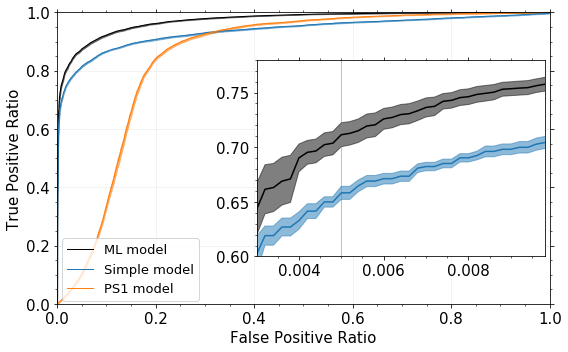

In [42]:
classifier = RandomForestClassifier(n_estimators = 250, 
                                                    min_samples_leaf = 1, 
                                                    max_features= 5, n_jobs=-1)

plot_ROC_curves(hst_tab[hst_det_mask], hst_tab[hst_det_mask][features], hst_GT[hst_det_mask], 
                n_splits=10, classifier=classifier, figname='CV_ROC_HST.pdf', savefig = True)

The FoM (FPR = 0.005) of the ML model and the simple model is $\sim 0.71$ and $\sim 0.66$, while that of the PS1 model is almost 0. 

Calculating the error of the accuracy: 012345678901234567890123456789Done.
Calculating PDFs : Done.



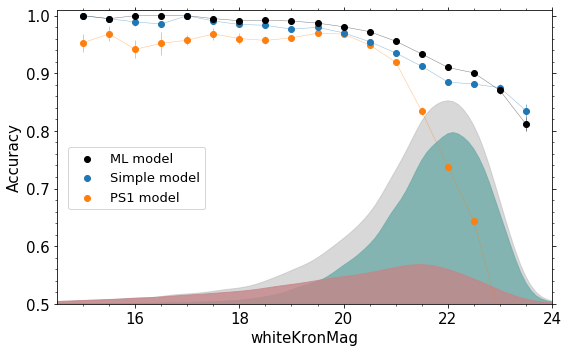

In [44]:
plot_ACU_curves(hst_tab[hst_det_mask][features], hst_tab[hst_det_mask], hst_GT[hst_det_mask], 
                figname='CV_Accuracy_HST.pdf', savefig=True, thre_method='info')